In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from keras.preprocessing import image
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

Using TensorFlow backend.


In [2]:
DATA_DIR = Path('../data/char_train_reviewed/')

In [3]:
classes_dirs = {path.name: path for path in sorted(DATA_DIR.iterdir())}
classes_dirs

{'0': PosixPath('../data/char_train_reviewed/0'),
 '1': PosixPath('../data/char_train_reviewed/1'),
 '2': PosixPath('../data/char_train_reviewed/2'),
 '3': PosixPath('../data/char_train_reviewed/3'),
 '4': PosixPath('../data/char_train_reviewed/4'),
 '5': PosixPath('../data/char_train_reviewed/5'),
 '6': PosixPath('../data/char_train_reviewed/6'),
 '7': PosixPath('../data/char_train_reviewed/7'),
 '8': PosixPath('../data/char_train_reviewed/8'),
 '9': PosixPath('../data/char_train_reviewed/9'),
 '?': PosixPath('../data/char_train_reviewed/?'),
 'A': PosixPath('../data/char_train_reviewed/A'),
 'B': PosixPath('../data/char_train_reviewed/B'),
 'C': PosixPath('../data/char_train_reviewed/C'),
 'D': PosixPath('../data/char_train_reviewed/D'),
 'E': PosixPath('../data/char_train_reviewed/E'),
 'F': PosixPath('../data/char_train_reviewed/F'),
 'G': PosixPath('../data/char_train_reviewed/G'),
 'H': PosixPath('../data/char_train_reviewed/H'),
 'I': PosixPath('../data/char_train_reviewed/I'),


In [4]:
cls_images = dict()

for y, dir_path in classes_dirs.items():
    cls_images[y] = [image.load_img(img_path, color_mode = "grayscale") 
                     for img_path in dir_path.glob("*.png")]

In [179]:
import matplotlib.pyplot as plt

def display_characters(chars):
    fig, axs = plt.subplots(1, len(chars))
    for i, letter in enumerate(chars):
        axs[i].imshow(letter)
        
    return fig
        

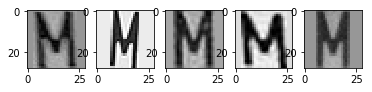

In [181]:
_ = display_characters(cls_images['M'][:5])
    

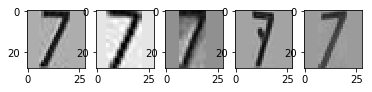

In [182]:
_ = display_characters(cls_images['7'][:5])

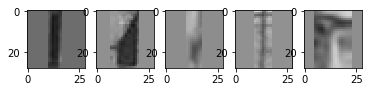

In [183]:
_ = display_characters(cls_images['?'][:5])

In [9]:
data = []

for y, images in cls_images.items():
    for im in images:
        im = image.img_to_array(im)
        data.append((im, y))
    
df = pd.DataFrame(data, columns=['image', 'label'])
df.sample(10, random_state=42).sort_index()

image label
413   [[[156.0], [156.0], [156.0], [156.0], [156.0],...     4
438   [[[159.0], [159.0], [159.0], [159.0], [159.0],...     4
490   [[[168.0], [168.0], [168.0], [168.0], [168.0],...     5
720   [[[221.0], [221.0], [221.0], [221.0], [221.0],...     8
838   [[[155.0], [155.0], [155.0], [155.0], [155.0],...     9
1111  [[[197.0], [197.0], [197.0], [197.0], [197.0],...     G
1156  [[[142.0], [142.0], [142.0], [142.0], [142.0],...     I
1446  [[[106.0], [106.0], [106.0], [106.0], [106.0],...     S
1465  [[[165.0], [165.0], [165.0], [165.0], [165.0],...     S
1626  [[[219.0], [219.0], [219.0], [219.0], [219.0],...     Y

In [10]:
df.label = df.label.astype('category')

X = np.stack(df.image.values) / 255
Y = df.label.cat.codes.values

In [11]:
num_classes = df.label.nunique()
num_classes

36

In [12]:
input_shape = X[0].shape
input_shape

(28, 28, 1)

In [57]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, InputLayer

model = Sequential()
model.add(InputLayer(input_shape, name="image"))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 name="conv2d_3x3_relu_1"))
model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_3x3_relu_2"))
model.add(MaxPooling2D(pool_size=(2, 2), name="max_pool_2x2"))
model.add(Dropout(0.25, name="dropout1_0.25"))
model.add(Flatten(name="flatten"))
model.add(Dense(128, activation='relu', name="fc_relu"))
model.add(Dropout(0.5, name="dropout2_0.5"))
model.add(Dense(num_classes, activation='softmax', name="fc_softmax"))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

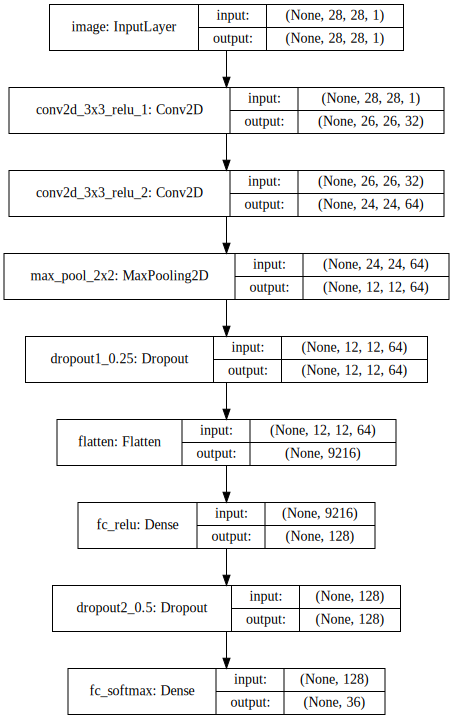

In [220]:
plot_model(model, to_file='model.pdf', show_shapes=True)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


For data augmentation examples check:
https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

In [215]:
shift_range = .1

datagen = image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=shift_range,
        height_shift_range=shift_range,
        shear_range=0.2,
        zoom_range=.1,
        fill_mode='nearest'
)

aug_prev_dir = '/tmp/alpr_aug'
os.makedirs(aug_prev_dir, exist_ok=True)

aug_generator = datagen.flow(X, Y, save_to_dir=aug_prev_dir)
_ = next(aug_generator) # iter to save examples for manual review

<Figure size 432x288 with 0 Axes>

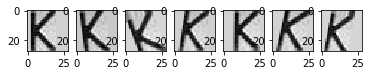

In [218]:
i = 1200
test_gen = datagen.flow(X[i:i+1], Y[i:i+1])

test_images = [next(test_gen)[0][0].reshape((28,28)) for i in range(7)]

plt.set_cmap("gray")
fig = display_characters(test_images)
plt.savefig("augmentation-k.pdf", bbox_inches='tight')

In [ ]:
batch_size = 64
epochs = 50

In [ ]:
aug_generator.save_to_dir = None # disable save for training part

model.fit_generator(aug_generator, 
                    epochs=epochs, 
                    steps_per_epoch=2000 // batch_size)

In [ ]:
model.fit_generator(aug_generator, 
                    epochs=epochs, 
                    steps_per_epoch=2000 // batch_size)

In [ ]:
model.fit_generator(aug_generator, 
                    epochs=200, 
                    steps_per_epoch=2000 // batch_size)

In [ ]:
model.fit_generator(aug_generator, 
                    epochs=100, 
                    steps_per_epoch=2000 // batch_size)

In [ ]:
model.save('../data/ocr-model-unknowns.h5')

In [ ]:
target_labels = df.label.unique()
target_labels

In [ ]:
def predict_character(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255
    preds = model.predict(x)

    return target_labels[np.argmax(preds)]

In [ ]:
def make_random_prediction():
    rand_char = np.random.choice(list(cls_images.keys()))
    chars = cls_images[rand_char]
    img = chars[np.random.choice(len(chars))]
    display(img)
    print("Predicted:", predict_character(img))

In [ ]:
for _ in range(10):
    make_random_prediction()